# Support vector machine & Random Forest

This notebook is divided into 3 main parts:
1. Data overview & preprocessing
2. Models and choice of parameters: Support-Vector Machine (implemented by sklearn.svm.LinearSVC) and Random Forest (implemented by sklearn.ensemble.ExtraTreesClassifier). 
3. Conclusions

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
import random as rm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from scipy.stats import norm, skew, randint
from sklearn.model_selection import cross_val_score, KFold,cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score ,confusion_matrix, classification_report

%matplotlib inline

### Load the dataset

In [2]:
df = pd.read_csv('mldata_0301522704.csv')
pd.set_option('display.max_columns', None)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 22 columns):
Unnamed: 0        1300 non-null int64
label             1300 non-null int64
num.feature 1     1300 non-null float64
num.feature 2     1300 non-null float64
num.feature 3     1300 non-null float64
num.feature 4     1300 non-null float64
num.feature 5     1300 non-null float64
num.feature 6     1300 non-null float64
num.feature 7     1300 non-null float64
num.feature 8     1300 non-null float64
num.feature 9     1300 non-null float64
num.feature 10    1300 non-null float64
num.feature 11    1300 non-null float64
num.feature 12    1300 non-null float64
num.feature 13    1300 non-null float64
num.feature 14    1300 non-null float64
num.feature 15    1300 non-null float64
num.feature 16    1300 non-null float64
num.feature 17    1300 non-null float64
num.feature 18    1300 non-null float64
num.feature 19    1300 non-null float64
num.feature 20    1300 non-null float64
dtypes: float64(2

In [4]:
all_train = 1300

In [5]:
columns = df.drop(['label'],axis = 1).values
y = df.label.values

I set aside 30% of the data, the validation set, which is disjoint from the training set and not allowed to be used when fitting the model. So I define a class for this purpose, which is similar to MnistTrain seen in class.  

I also do a PCA with 90%.  
I am also going to add a "normalization option" to the class:  
Random Forest is invariant to monotonic transformations of individual features, so per feature scalings will not change anything for the Random Forest. SVM will probably do better if features have roughly the same magnitude (which is already true, features have means around 0 and similar stardard deviation) but I will normalize them anyway just to be sure everything works fine.

In [6]:
class valid_data:
    def __init__(self, num_train = 910, num_valid = 390, seed = 30227, n_components = 0.9, norm = False, columns = columns):
        np.random.seed(seed)
        perm = np.random.permutation(all_train)
        dopca = n_components is None or n_components > 0
        
        i_train = perm[:num_train]
        i_valid = perm[num_train:num_train+num_valid]

        train_data = columns[i_train,:]
        train_target = y[i_train]
        valid_data = columns[i_valid,:]
        valid_target = y[i_valid]
        
        if dopca:
            pca = PCA(n_components = n_components)
            pca.fit(train_data)
            X = pca.transform(train_data)
            vX = pca.transform(valid_data)
        else:
            X, vX = train_data, valid_data
            
        if norm == True: 
            scaler = StandardScaler()
            scaler.fit(train_data)
            X = scaler.transform(train_data)
            vX = scaler.transform(valid_data)
        else:
            X, vX = train_data, valid_data

        nc = X.shape[1]
#        print('nc=%i' % X.shape[1])
        
        self.perm = perm
        self.X, self.y = X, train_target
        self.vX, self.vy = vX, valid_target
        self.pca = pca if dopca else None
    
    def train(self):
        return self.X, self.y
    
    def valid(self):
        return self.vX, self.vy

# Data overview

In [7]:
df.describe()

,Unnamed: 0,label,num.feature 1,num.feature 2,num.feature 3,num.feature 4,num.feature 5,num.feature 6,num.feature 7,num.feature 8,num.feature 9,num.feature 10,num.feature 11,num.feature 12,num.feature 13,num.feature 14,num.feature 15,num.feature 16,num.feature 17,num.feature 18,num.feature 19,num.feature 20
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000
mean,649.500000,1.972308,0.117639,-0.101672,-0.054755,-0.166105,0.072461,-0.034209,-0.250256,-0.038126,0.168828,0.128200,-0.091922,0.083364,0.081069,0.220551,-0.069147,-0.009406,0.056756,-0.050262,-0.011994,-0.117237
std,375.421985,1.448368,1.387275,1.626914,1.819147,1.184847,2.089788,1.644535,1.563757,1.089429,1.546943,1.363908,1.400627,1.390795,1.411237,1.228115,1.871668,1.607915,1.423297,1.094152,1.221542,1.507787
min,0.000000,0.000000,-3.677611,-5.961574,-6.569405,-3.962740,-6.299933,-5.870734,-5.452610,-4.179753,-4.779253,-4.442563,-5.225851,-4.224787,-4.078816,-4.212993,-6.747280,-5.415846,-4.876416,-3.467864,-4.336936,-5.345597
25%,324.750000,1.000000,-0.855651,-1.112877,-1.283179,-0.972195,-1.243690,-1.110134,-1.318638,-0.780279,-0.853953,-0.813182,-1.018493,-0.811081,-0.910287,-0.570969,-1.319130,-1.087796,-0.902832,-0.804935,-0.887561,-1.084091
50%,649.500000,2.000000,0.093485,-0.186854,0.013099,-0.185657,0.104028,0.004837,-0.257762,-0.041549,0.144209,0.157351,-0.162941,0.044468,0.077447,0.213775,-0.129995,-0.044510,0.020383,-0.049158,0.001555,-0.118627
75%,974.250000,3.000000,1.057629,0.877016,1.170985,0.616176,1.472452,1.137264,0.861766,0.716434,1.164693,1.019633,0.737137,0.979501,1.052053,1.002043,1.095532,0.957833,0.989495,0.702683,0.834988,0.905893
max,1299.000000,4.000000,4.522937,5.500374,6.396728,4.444597,7.114473,4.612252,4.995067,3.556556,6.492979,5.005825,5.399911,4.598449,4.797983,4.134452,6.750309,5.862843,5.727670,3.635579,4.075069,4.020739


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 22 columns):
Unnamed: 0        1300 non-null int64
label             1300 non-null int64
num.feature 1     1300 non-null float64
num.feature 2     1300 non-null float64
num.feature 3     1300 non-null float64
num.feature 4     1300 non-null float64
num.feature 5     1300 non-null float64
num.feature 6     1300 non-null float64
num.feature 7     1300 non-null float64
num.feature 8     1300 non-null float64
num.feature 9     1300 non-null float64
num.feature 10    1300 non-null float64
num.feature 11    1300 non-null float64
num.feature 12    1300 non-null float64
num.feature 13    1300 non-null float64
num.feature 14    1300 non-null float64
num.feature 15    1300 non-null float64
num.feature 16    1300 non-null float64
num.feature 17    1300 non-null float64
num.feature 18    1300 non-null float64
num.feature 19    1300 non-null float64
num.feature 20    1300 non-null float64
dtypes: float64(2

The dataset is composed by an Unnamed:0 column which I will delete, one label column containing 5 classes (0,1,2,3,4) and 20 numeric features: all the columns have size 1300. There are no categorical or missing data.

In [9]:
del df['Unnamed: 0']

Now I plot the histograms to show what the data's distributions looks like, I observe than the are also normally distributed, more or less.

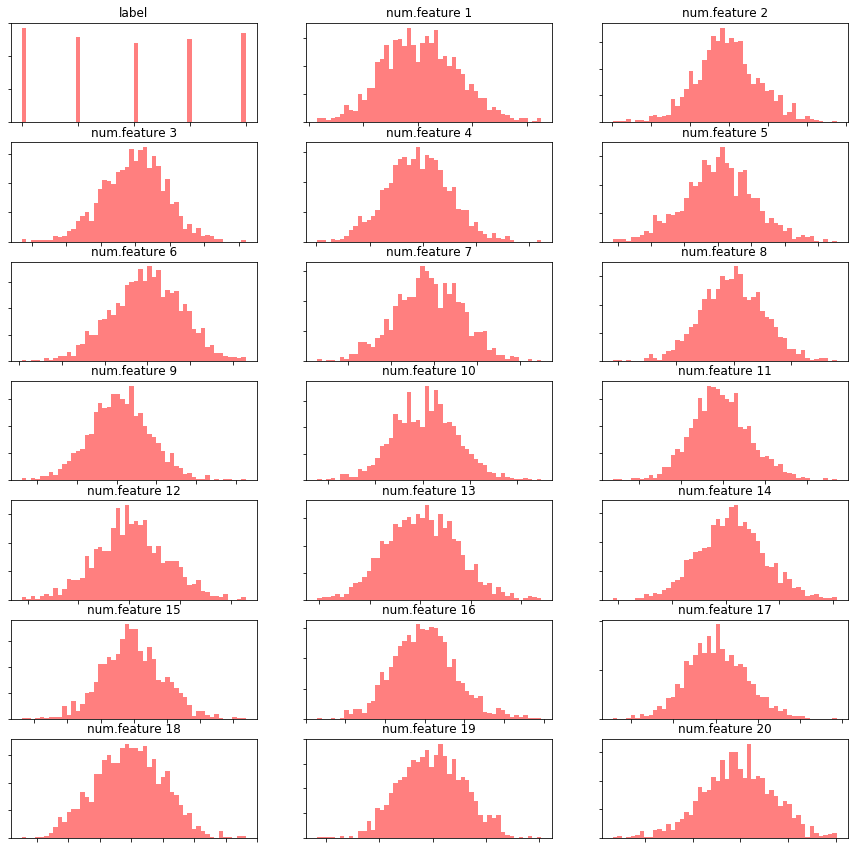

In [10]:
fig, axes = plt.subplots(nrows = 7, ncols = 3, figsize = (15,15))
axes = axes.flatten()

cols = df.columns
for i in range(21):
    axes[i].hist(df[cols[i]], bins = 50, facecolor = 'r', alpha = 0.5)
    axes[i].set_title(cols[i])
    plt.setp(axes[i].get_xticklabels(), visible = False) 
    plt.setp(axes[i].get_yticklabels(), visible = False)

[Text(0,0.5,'label'),
 Text(0,1.5,'num.feature 1'),
 Text(0,2.5,'num.feature 2'),
 Text(0,3.5,'num.feature 3'),
 Text(0,4.5,'num.feature 4'),
 Text(0,5.5,'num.feature 5'),
 Text(0,6.5,'num.feature 6'),
 Text(0,7.5,'num.feature 7'),
 Text(0,8.5,'num.feature 8'),
 Text(0,9.5,'num.feature 9'),
 Text(0,10.5,'num.feature 10'),
 Text(0,11.5,'num.feature 11'),
 Text(0,12.5,'num.feature 12'),
 Text(0,13.5,'num.feature 13'),
 Text(0,14.5,'num.feature 14'),
 Text(0,15.5,'num.feature 15'),
 Text(0,16.5,'num.feature 16'),
 Text(0,17.5,'num.feature 17'),
 Text(0,18.5,'num.feature 18'),
 Text(0,19.5,'num.feature 19'),
 Text(0,20.5,'num.feature 20')]

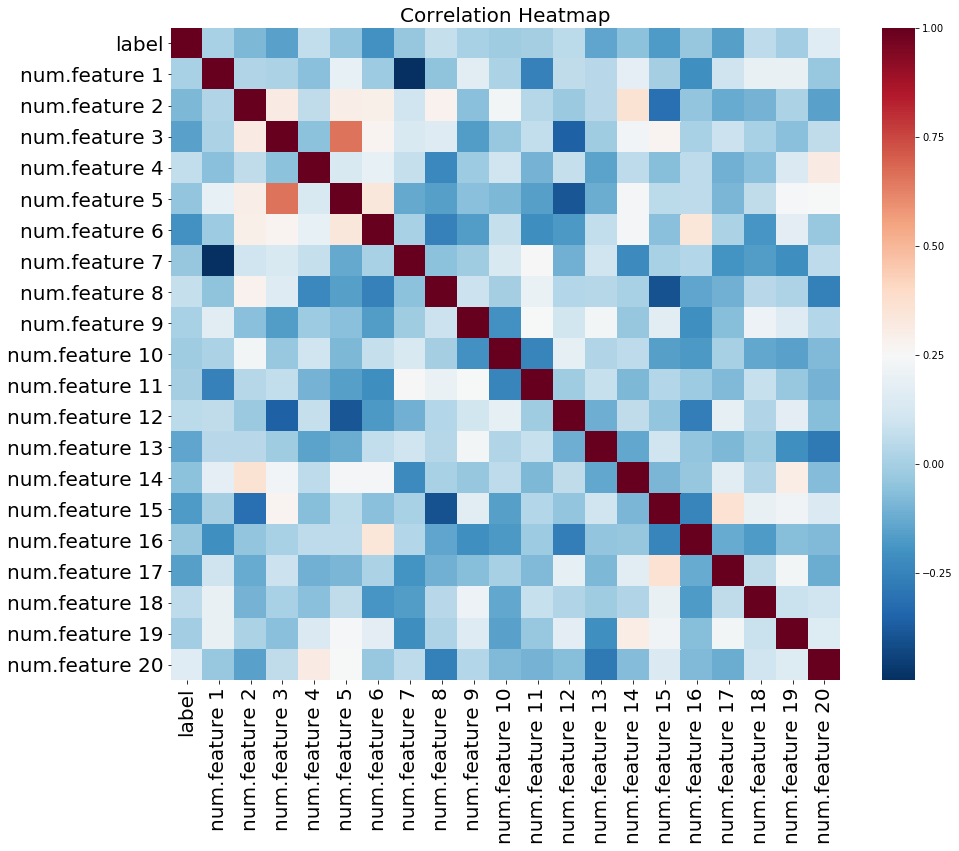

In [11]:
corr=df.corr()
#Check out the Correlation Headmap
plt.figure(figsize=(15,12))
p = sns.heatmap(corr, cmap="RdBu_r")
p.set_title('Correlation Heatmap', fontsize=20)
p.set_xticklabels(p.get_xticklabels(),fontsize=20)
p.set_yticklabels(p.get_yticklabels(),fontsize=20)

It is clear than feature 1 and 7 are very much negatively correlated, while 3 and 5 are positive correlated.

Correlated features in general don't improve models, and they might be a problem with random forest, should I delete them?

In [12]:
df['num.feature 3'].corr(df['num.feature 5'])

0.65745964631664555

In [13]:
columns1 = df.drop(['label','num.feature 3'],axis = 1).values

It's pretty high, I'll remove it before random forest

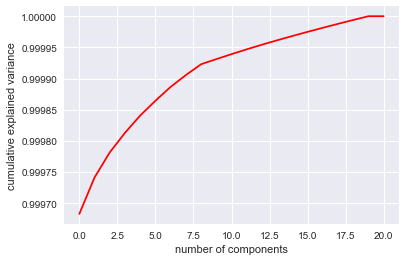

In [14]:
sns.set()
pca = PCA().fit(columns)
plt.plot(np.cumsum(pca.explained_variance_ratio_),"r")
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

8 components explain almost all cumulative explained variance

Check the skewness of Numeric Features: this is why we normalize a the features 

In [15]:
df_new=df.drop(['label'],axis=1)
skewed_feat = df_new.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
pd.DataFrame({'Skew' :skewed_feat})

,Skew
num.feature 16,0.272232
num.feature 11,0.200310
num.feature 1,0.164111
num.feature 17,0.131857
num.feature 13,0.120673
num.feature 15,0.115903
num.feature 9,0.109466
num.feature 4,0.085711
num.feature 14,0.052897
num.feature 10,0.051408


## Random forest

Final training score = 0.430303, validation score = 0.430303
Feature ranking:
1. feature 10 (0.056384)
2. feature 13 (0.056268)
3. feature 14 (0.054031)
4. feature 12 (0.053718)
5. feature 3 (0.052246)
6. feature 16 (0.051229)
7. feature 17 (0.049365)
8. feature 20 (0.049005)
9. feature 18 (0.047807)
10. feature 6 (0.047700)
11. feature 7 (0.047139)
12. feature 2 (0.047097)
13. feature 9 (0.046214)
14. feature 21 (0.044759)
15. feature 11 (0.044520)
16. feature 4 (0.044320)
17. feature 15 (0.043896)
18. feature 19 (0.042777)
19. feature 8 (0.042374)
20. feature 5 (0.039580)
21. feature 1 (0.039574)


(-1, 21)

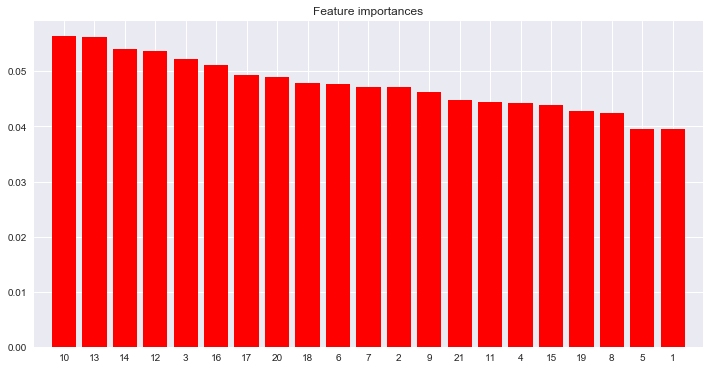

In [25]:
data = valid_data(num_train = 770, num_valid = 330, seed = 30227)
    
clf = ExtraTreesClassifier()
clf.fit(*data.train())
train_score = clf.score(*data.train())
test_score = clf.score(*data.valid())
print("Final training score = %g, validation score = %g" % (test_score, test_score))

#plot the features importances
imp = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
indices = np.argsort(imp)[::-1]
print("Feature ranking:")
fe, ta = data.train()
for f in range(fe.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f]+1, imp[indices[f]]))
        
# Plot the feature importances of the forest
plt.figure(figsize = (12,6))    
plt.title("Feature importances")
plt.bar(range(fe.shape[1]), imp[indices], color='r', align="center")
plt.xticks(range(fe.shape[1]), indices + 1)
plt.xlim([-1, fe.shape[1]])

## Parameters tuning
I need to choose the best parameters, while making some considerations:
- n_estimators, when increased is good at dealing with overfitting;
- min_sample_split is also helpful when dealing with overfitting occurred in a small-sample but big-features dataset (can 1300 be considered small sample, and 20 be considered a high number of features?)
- max_features is worth exploring for many different values. It may have a large impact on the Random Forest because it controls the maximum number of features each tree considers at each split.
- criterion may have a small impact, I will try gini and entropy

In [17]:
#Perform Randomized Search on ExtraTree
clf_Ext = ExtraTreesClassifier()
param_dist = {'criterion' :['gini','entropy'],
              'n_estimators' : np.arange(5,500,dtype = int),
              'min_samples_split' : np.arange(2,50,dtype = int),
              'max_features' : ['auto', 'sqrt']}

n_iter_search = 35
random_search = RandomizedSearchCV(clf_Ext, param_distributions = param_dist)
data = valid_data(num_train = 770, num_valid = 330, n_components = 8, columns = columns1)
random_search.fit(*data.train())
print(random_search.best_params_)

{'n_estimators': 169, 'min_samples_split': 2, 'max_features': 'sqrt', 'criterion': 'entropy'}


So I start with these best parameters:  
'n_estimators': 169  
'min_samples_split': 2   
'max_features': 'sqrt'  
'criterion': 'entropy'  

Now plot training and test, so that I can decide which parameters are actually best.

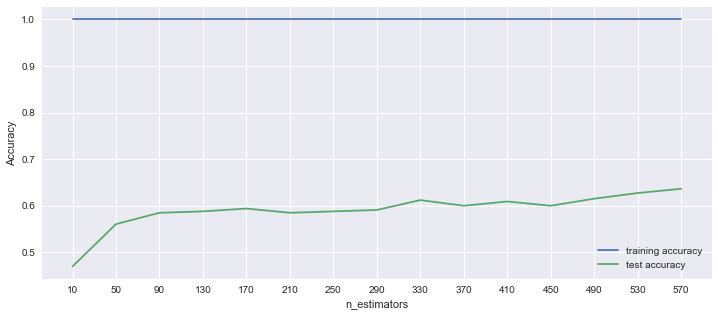

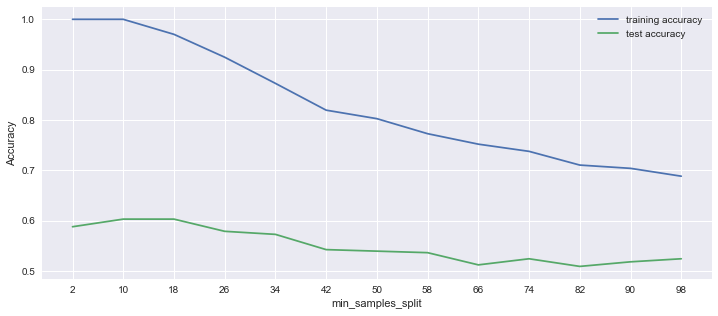

In [18]:
n_estimators=list(np.arange(10,500,step = 40,dtype = int))
min_samples_split = list(np.arange(2,100,step = 8,dtype = int))
test_score1 = []
train_score1 = []
test_score2 = []
train_score2 = []

for i in n_estimators:
    mod1 = ExtraTreesClassifier(n_estimators=i,min_samples_split=2,max_features = 'sqrt',criterion = "entropy")
    data = valid_data(num_train = 770, num_valid = 330, n_components = 8,columns = columns1)
    mod1.fit(*data.train())
    train_score1.append(mod1.score(*data.train()))
    test_score1.append(mod1.score(*data.valid()))
    
for i in min_samples_split:
    mod2 = ExtraTreesClassifier(n_estimators=169,min_samples_split=i,max_features = 'sqrt',criterion = "entropy")
    data = valid_data(num_train = 770, num_valid = 330, n_components = 8,columns = columns1)
    mod2.fit(*data.train())
    train_score2.append(mod2.score(*data.train()))
    test_score2.append(mod2.score(*data.valid()))
    
plt.figure(figsize = (12,5))    
plt.plot(n_estimators,train_score1, label='training accuracy')
plt.plot(n_estimators,test_score1, label='test accuracy')
plt.ylabel('Accuracy')
plt.xlabel('n_estimators')
plt.xticks(n_estimators)
plt.legend();


plt.figure(figsize = (12,5))    
plt.plot(min_samples_split,train_score2, label='training accuracy')
plt.plot(min_samples_split,test_score2, label='test accuracy')
plt.ylabel('Accuracy')
plt.xlabel('min_samples_split')
plt.xticks(min_samples_split)
plt.legend();

Even though there might be a little overfitting, for the final model I decide these paramters (based on the graphs above):

In [19]:
data = valid_data(num_train = 770, num_valid = 330, seed = 30227, columns = columns1)
    
clf_final_1 = ExtraTreesClassifier(n_estimators=330,min_samples_split=2,criterion = "entropy")
clf_final_1.fit(*data.train())
train_score_f1 = clf_final_1.score(*data.train())
test_score_f1 = clf_final_1.score(*data.valid())
print("Final validation score = %g" % (test_score_f1))

Final validation score = 0.645455


Almost 65% , it's good.

## SVM

The main parameter to tune is of course C, I also look for the best options among penalty, loss.

In [20]:
data = valid_data(num_train = 770, num_valid = 330, seed = 30227,norm = True)


param_distr ={'C' : list(np.arange(0.01,10,step = 0.1)), 
              'loss' : ['hinge','squared_hinge'],
              'multi_class': ['ovr','crammer_singer']
             }

# create and fit a SVM model.
n_search_iter = 20
model = LinearSVC(penalty = 'l2')
rCV = RandomizedSearchCV(model, param_distr, n_search_iter)
rCV.fit(*data.train())

rbest_params = rCV.best_params_
rvalidation_accuracy = rCV.score(*data.valid())
print('Validation accuracy: ', rvalidation_accuracy)
print('The best parameters are:', rCV.best_params_)   

Validation accuracy:  0.469696969697
The best parameters are: {'multi_class': 'ovr', 'loss': 'squared_hinge', 'C': 6.6100000000000003}


Validation accuracy:  0.469696969697
The best parameters are: {'multi_class': 'ovr', 'loss': 'squared_hinge', 'C': 6.6100000000000003}

"ovr" trains n_classes one-vs-rest classifiers. I only tune C.

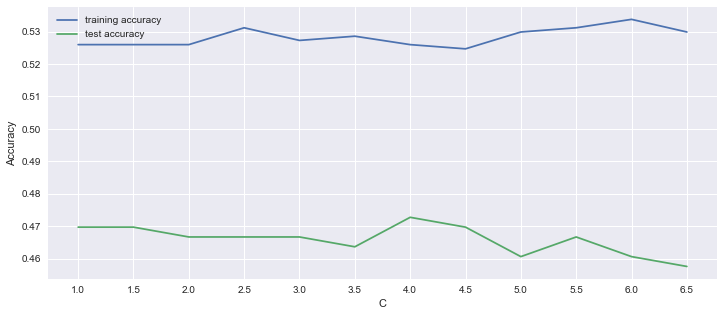

In [21]:
C=list(np.arange(1,7,step = 0.5))
gamma = list(np.arange(0.01,1,step = 0.05))
    
test_score1 = []
train_score1 = []

for i in C:
    mod1 = LinearSVC(C=i, loss = 'squared_hinge',multi_class = 'ovr')
    data = valid_data(num_train = 770, num_valid = 330, norm = True)
    mod1.fit(*data.train())
    train_score1.append(mod1.score(*data.train()))
    test_score1.append(mod1.score(*data.valid()))
    

    
plt.figure(figsize = (12,5))    
plt.plot(C,train_score1, label='training accuracy')
plt.plot(C,test_score1, label='test accuracy')
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.xticks(C)
plt.legend();


In [22]:
data = valid_data(num_train = 770, num_valid = 330, seed = 30227,norm = True)
    
clf_final_2 = LinearSVC(C=4.0, loss = 'squared_hinge',multi_class = 'ovr')
clf.fit(*data.train())
train_score_f2 = clf.score(*data.train())
test_score_f2 = clf.score(*data.valid())
print("Final validation score = %g" % (test_score_f2))

Final validation score = 0.430303


# Conclusion

In [23]:
test_score_f1

0.6454545454545455

In [24]:
test_score_f2

0.4303030303030303

Random Forest performs much better than the Linear SVM. I know that the Random Forest can be better to handle noise in the data because of ensemble technique. The Linear SVM failed to reach an high accuracy score, this might be due to the fact that it uses linear kernel function and it might not be the best method to implement this dataset.

In the end, the result achieved by RF is pretty good, that is the best model and it seems much faster than Linear SVM.